In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [2]:
!gdown https://drive.google.com/uc?id=12bhjBdCP-uHePIoW020uvu5wg-G7vLH9 

Downloading...
From: https://drive.google.com/uc?id=12bhjBdCP-uHePIoW020uvu5wg-G7vLH9
To: /content/Dataset.zip
100% 52.1M/52.1M [00:01<00:00, 26.5MB/s]


In [3]:
!unzip -q Dataset.zip -d $'./'

## Import the required libs

In [1]:
import itertools
import os
import random
from pickle import dump, load

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import load_model
from numpy import argmax
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tqdm import tqdm

## Digits classification model

In [5]:
class DigitClassification(object):
    def __init__(
        self,
        filter: list = [16, 32, 64, 128, 256],
        kernel_size: list = [(3, 3), (2, 2)],
        dr_rate: float = 0.2,
        input_shape: tuple = (28, 28, 1),
        output_layer: int = 10,
    ) -> None:
        """Initialize Digits classification.

        Args:
            filter: Number filter of convolution layer. Defaults to [16, 32, 64, 128].
            kernel_size: The shape of kernel. Defaults to [(3, 3), (2, 2)].
            input_shape: Input of model. Defaults to (28, 28, 1).
            output_layer: Output of model. Defaults to 10.
        """
        self._model = None
        self._filter = filter
        self._kernel_size = kernel_size
        self._dr_rate = dr_rate
        self._input_shape = input_shape
        self._output_layer = output_layer

        self._fig_size = (15, 15)
        self._rows = 3
        self._columns = 4

    def processing_data(self) -> None:
        """Dump data into numpy array"""

        X_train = np.array(self._pre_processing("/content/Images/train", 28))
        X_test = np.array(self._pre_processing("/content/Images/test", 28))

        self._X_test_display = X_test

        """Tips when use with big data.
            with open('train.pkl', 'wb') as encoded_train:
                dump(X_train, encoded_train)
            with open('test.pkl', 'wb') as encoded_test:
                dump(X_test, encoded_test)

            X_train = load(open("./train.pkl", "rb"))
            X_test = load(open("./test.pkl", "rb"))
        """

        df = pd.read_csv("./train.csv")
        label = df["label"].values.tolist()
        y_train = np.array(label)

        self._split_data(X_train, X_test, y_train)

    def _pre_processing(self, dir: str, resize: int) -> np.ndarray:
        """Pre-processing data.

        Args:
            dir: Root directory of data.
            resize: Resize data as same as the input of model.

        Returns: Numpy array.
        """
        imgs = []
        img_list = sorted(os.listdir(dir), key=lambda x: int(x[: -len(".png")]))

        for image_name in tqdm(img_list):
            path = os.path.join(dir, image_name)
            _, ftype = os.path.splitext(path)
            if ftype == ".png":

                img = np.asarray(Image.open(path))

                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (resize, resize))

                imgs.append(np.array(img))

        return imgs

    def _split_data(
        self, X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray
    ) -> None:
        """Split data for train, validation and test.

        Args:
            X_train: A train data.
            X_test: A test data.
            y_train: Label of train data
        """
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.25
        )

        self._X_train_display = X_train

        self._X_train = self._post_processing(X_train)
        self._X_val = self._post_processing(X_val)
        self._X_test = self._post_processing(X_test)

        self._y_val = y_val
        self._y_train = y_train

    def _post_processing(self, X_data: np.ndarray) -> np.ndarray:
        """Post-processing data.

        Args:
            X_data: Data without normalize.

        Returns: Data after mormalize.
        """
        # Reshape data to 1 channel
        X_data = X_data.reshape((X_data.shape[0], 28, 28, 1))

        # Normalize data range 0-1
        X_data = X_data.astype("float32") / 255.0

        return X_data

    def plot(self) -> None:
        """Visualize some data with label of them."""
        fig = plt.figure(figsize=self._fig_size)

        for idx in range(1, self._columns * self._rows + 1):
            ax = fig.add_subplot(self._rows, self._columns, idx)
            plt.title("Number: " + str(self._y_train[idx]))
            plt.imshow(self._X_train_display[idx])
        plt.show()

    def _define_model(self) -> None:
        """Define digits classification model."""
        model = Sequential()
        model.add(
            Conv2D(
                self._filter[1],
                self._kernel_size[0],
                activation="relu",
                input_shape=self._input_shape,
            )
        )
        model.add(MaxPooling2D(self._kernel_size[1]))
        model.add(Flatten())
        model.add(Dense(self._filter[3], activation="relu"))
        model.add(Dropout(self._dr_rate))
        model.add(Dense(self._output_layer, activation="softmax"))
        model.summary()

        self._model = model

    def _compile_model(self) -> None:
        """Compile the model."""
        self._define_model()
        self._model.compile(
            loss="sparse_categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy"],
        )

    def train(self) -> None:
        """Train model."""
        self._compile_model()

        _filepath = "top.weights.hdf5"
        _checkpoint = ModelCheckpoint(
            _filepath, monitor="val_accuracy", verbose=1, save_best_only=True, mode=max
        )
        _callbacks_list = [_checkpoint]

        self._H = self._model.fit(
            self._X_train,
            self._y_train,
            validation_data=(self._X_val, self._y_val),
            epochs=40,
            batch_size=32,
            callbacks=_callbacks_list,
            verbose=2,
        )

    def visualize(self) -> None:
        """Visualize accuracy and loss."""
        fig = plt.figure()
        # Plot accuracy and val_accuracy
        plt.plot(self._H.history["accuracy"])
        plt.plot(self._H.history["val_accuracy"])
        plt.xlabel("epochs")
        plt.ylabel("accuracy and val_accuracy")
        plt.title("accuracy")
        plt.legend(["train", "val"], loc="upper left")
        plt.show()

        plt.figure()
        # Plot loss and val_loss
        plt.plot(self._H.history["loss"])
        plt.plot(self._H.history["val_loss"])
        plt.xlabel("epochs")
        plt.ylabel("loss and val_loss")
        plt.title("loss")
        plt.legend(["train", "val"])
        plt.show()

    def evaluate_model(self) -> None:
        """Evaluate the model."""
        loss, acc = self._model.evaluate(self._X_val, self._y_val, verbose=2)
        print("Accuracy: %.3f" % acc)
        print("Loss: %.3f" % loss)

    def predict_model(self) -> None:
        """Prediction."""
        y_pred = self._model.predict(self._X_test)

        fig = plt.figure(figsize=(15, 15))
        columns = 4
        rows = 3

        for i in range(1, columns * rows + 1):
            ax = fig.add_subplot(rows, columns, i)
            idx = random.randint(0, self._X_test.shape[0])
            plt.title("Predicted: " + str(np.argmax(y_pred[idx])))
            plt.imshow(self._X_test_display[idx])
        plt.show()

    def _plot_confusion_matrix(
        self,
        cm: np.ndarray,
        classes: list,
        normalize: bool = False,
        title: str = "Confusion matrix",
        cmap=plt.cm.Blues,
    ) -> None:
        """Visualize confusion matrix."""
        plt.imshow(cm, interpolation="nearest", cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        thresh = cm.max() / 2.0
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(
                j,
                i,
                cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
            )

        plt.tight_layout()
        plt.ylabel("True label")
        plt.xlabel("Predicted label")

    def cf_matrix(self) -> None:
        """Confusion matrix metric."""
        # Predict the values from the validation dataset
        y_val_pred = self._model.predict(self._X_val)

        # Convert predictions classes to one hot vectors
        y_val_pred_classes = np.argmax(y_val_pred, axis=1)

        # Compute the confusion matrix
        confusion_mtx = confusion_matrix(self._y_val, y_val_pred_classes)

        # Plot the confusion matrix
        self._plot_confusion_matrix(confusion_mtx, classes=range(10))

    def save_predict_to_csv(self) -> None:
        """Save predict to csv file."""
        y_pred = self._model.predict(self._X_test)

        y_predicted = [np.argmax(y_pred[i]) for i in range(y_pred.shape[0])]

        file_name = [str(idx) + ".png" for idx in range(49000, 70000, 1)]

        dict = {"filename": file_name, "label": y_predicted}

        df = pd.DataFrame(dict)

        # Saving the dataframe
        df.to_csv("results.csv")

In [6]:
model = DigitClassification()

In [7]:
model.processing_data()

100%|██████████| 21000/21000 [00:03<00:00, 6213.45it/s]


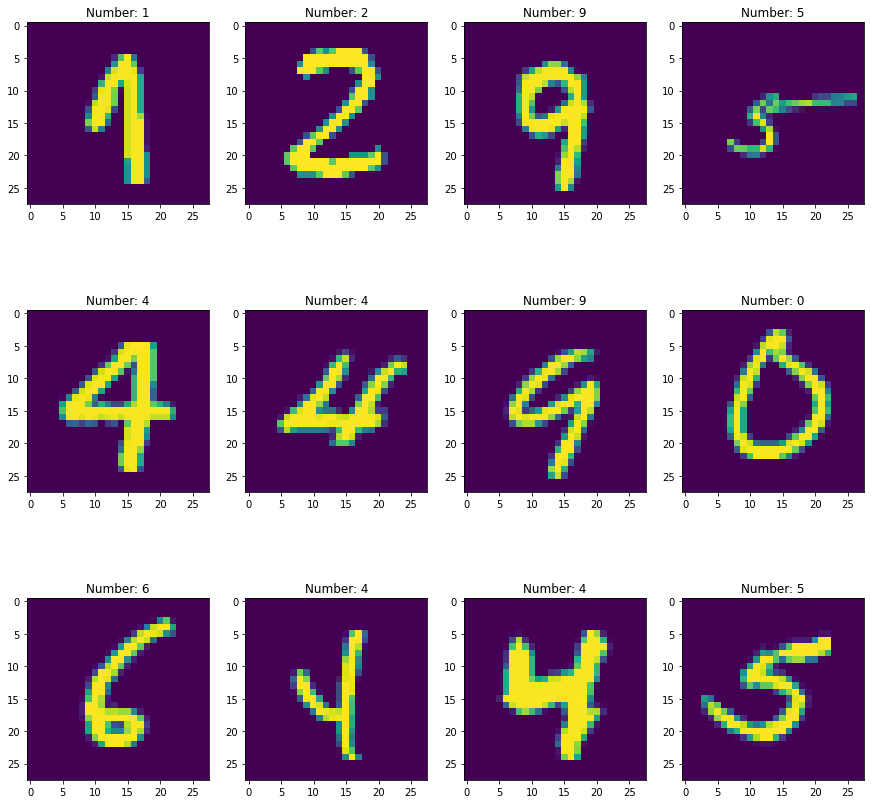

In [8]:
model.plot()

In [9]:
model.train()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               692352    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

Epoch 1/40

Epoch 1: val_accuracy improved from -inf to 0.97004, saving model to top.weights.hdf5
1149/1149 - 14s - loss: 0.2201 - accuracy: 0.9336 - val_loss: 0.0916 - val_accuracy: 0.9700 - 14s/epoch - 12ms/step
Epoch 2/40

Epoch 2: val_accuracy improved from 0.97004 to 0.97812, saving model to top.weights.hdf5
1149/1149 - 4s - loss: 0.0766 - accuracy: 0.9762 - val_loss: 0.0665 - val_accuracy: 0.9781 - 4s/epoch - 4ms/step
Epoch 3/40

Epoch 3: val_accuracy improved from 0.97812 to 0.98073, saving model to top.weights.hdf5
1149/1149 - 4s - loss: 0.0531 - accuracy: 0.9835 - val_loss: 0.0600 - val_accuracy: 0.9807 - 4s/epoch - 4ms/step
Epoch 4/40

Epoch 4: val_accuracy improved from 0.98073 to 0.98286, saving model to top.weights.hdf5
1149/1149 - 4s - loss: 0.0389 - accuracy: 0.9874 - val_loss: 0.0559 - val_accuracy: 0.9829 - 4s/epoch - 4ms/step
Epoch 5/40

Epoch 5: val_accuracy improved from 0.98286 to 0.98327, saving model to top.weights.hdf5
1149/1149 - 5s - loss: 0.0301 - accuracy: 0

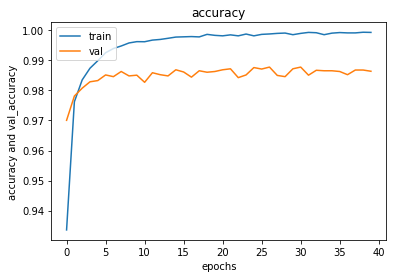

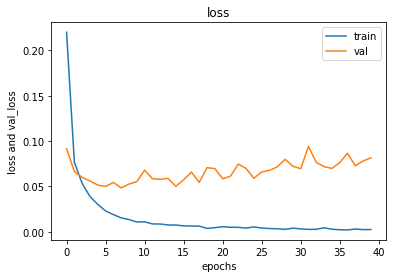

In [10]:
model.visualize()

In [11]:
model.evaluate_model()

383/383 - 1s - loss: 0.0815 - accuracy: 0.9864 - 784ms/epoch - 2ms/step
Accuracy: 0.986
Loss: 0.081


657/657 [==============================] - 1s 2ms/step


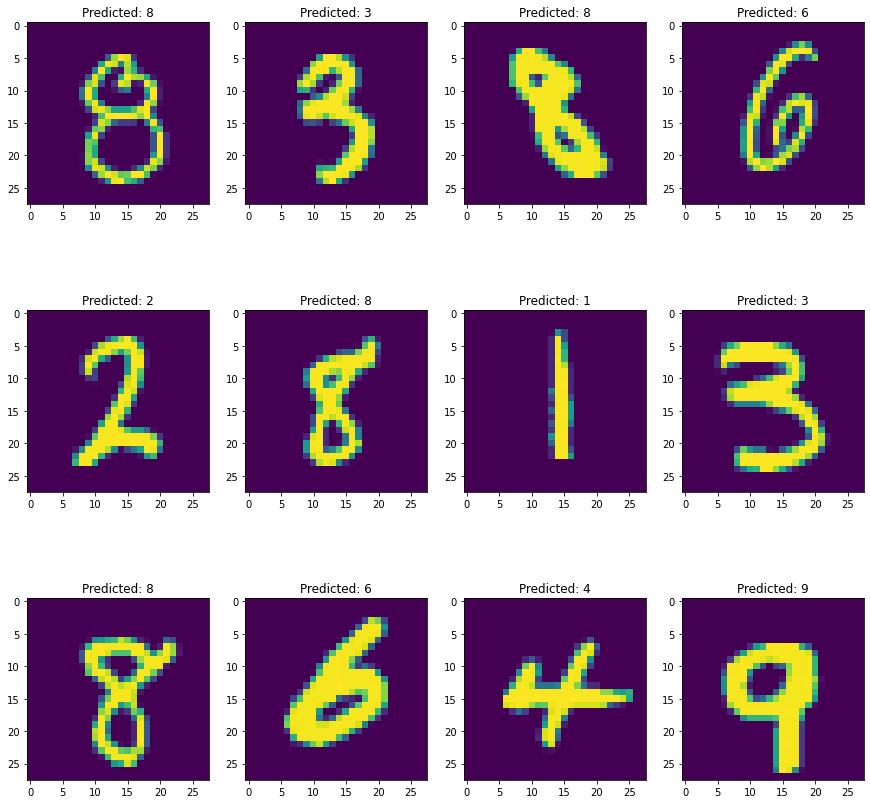

In [12]:
model.predict_model()

383/383 [==============================] - 1s 2ms/step


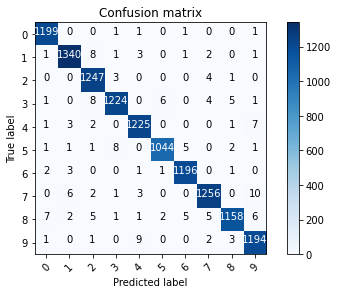

In [13]:
model.cf_matrix()

In [ ]:
model.save_predict_to_csv()